In [1]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#Using newest versions of all libraries

In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *
from imcal import CalorimeterDataset
from imcal import Hdf5Dataset
from imcal import RandomRoll
from imcal import plot_conf_matrix

In [3]:
#variables controlled by the user. Change these to fit your specific needs.
TRAIN_N_EVENTS = 1000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
TEST_N_EVENTS = 3000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
RES = 100 #resolution

#Data specification
LABELS = ["BH_n5_M8", "SPH_9"]
TRAIN_FILENAMES = [f"BH_n5_M8_res{RES}_10000_events.h5", f"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res{RES}_10000_events.h5"]
TEST_FILENAMES = [f"BH_n5_M8_res{RES}_3000_events.h5", f"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res{RES}_3000_events.h5"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
TRAIN_DATAPATH = Path(f"/disk/atlas3/data_MC/2dhistograms/sph_BH/training/{RES}/") #The path to the folder containing the training histogram files
TEST_DATAPATH = Path(f"/disk/atlas3/data_MC/2dhistograms/sph_BH/testing/{RES}/") #The path to the folder containing the testing histogram files

MODEL_NAME = f'resnet_{str(int(time.time()))}' #A unique name for the model
print(MODEL_NAME)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

#Data processing
#filters=["saturate"]
filters=None
transforms = torch.nn.Sequential(
        torchv.transforms.RandomVerticalFlip(),
        #torchv.transforms.RandomHorizontalFlip(),
        RandomRoll(1)
    )
#transforms=None

resnet_1668173142
Running on the GPU


In [9]:
class Hdf5Dataset(Dataset):
	
	def __init__(
		self,
		path: Union[Path,str],
		labels: list[str],
        device: torch.device,
		shuffle: bool = True,
		transform: Optional[Callable] = None,
		event_limit: Optional[int] = None

	):
		r"""
		Args:
			path (Path or str): Path to directory containing HDF5 files, with .h5 suffix 
			shuffle (bool): Randomize order of events. Always enable for training, 
				otherwise all batches will contain a single class only. Optionally enable
				shuffling in DataLoader
			transform (Callable, optional): Function for data transforms
			event_limit (int, optional): Limit number of events in dataset 
		"""
		super().__init__()
		
		self.path = path
		self.labels = labels
		self.device = device
		self.shuffle = shuffle
		self.transform = transform
		self.event_limit = event_limit

		# Get file list
		if not isinstance(path, Path):
			path = Path(path)
		
		filenames = path.glob('*.h5')
		
		# Open file descriptors and get event keys
		# Store file name along with key, to keep track
		self._files = {}
		self._event_keys = []
		for full_file_path in filenames:
			fd = h5py.File(full_file_path, 'r')
			filename = full_file_path.name.__str__()
			self._files[filename] = fd
			# Limit number of events
			if event_limit:
				event_keys = list(fd.keys())[:event_limit]
			else:
				event_keys = list(fd.keys())
			event_keys = [(filename, key) for key in event_keys]
			self._event_keys += event_keys
		
		assert len(self._files) > 0, f'No files found in {path}'
		
		# Shuffle keys
		if (shuffle):
			randomshuffle(self._event_keys)


	def __len__(self):
		return len(self._event_keys)

	def __getitem__(self, idx):
		
		if torch.is_tensor(idx):
			idx = idx.tolist()
		
		filename, key = self._event_keys[idx]
		group = self._files[filename].get(key)

		#convert label from string to tensor
		label = group.get('label')[()].decode()
		label = self.label_maker(label, self.labels)
		
		#data
		data = group.get('data')[()]
		# GTX cards are single precision only
		#data = data.astype(np.float32)
		data = torch.from_numpy(data)
		if self.transform:
			data = self.transform(data)

		return (data.to(self.device), label.to(self.device))

	def label_maker(self, value, labels):
		#Creates labels for the classes. The first class gets value [1, 0, .., 0], the next [0, 1, ..., 0] etc
		#Outputs a tensor
		for i, label in enumerate(labels):
			if value in label:
				idx = i
		vector = np.zeros(len(labels))
		vector[idx] = 1
		return torch.from_numpy(vector)


In [10]:
#load data in memory
"""
trainpaths = [Path(TRAIN_DATAPATH/file) for file in TRAIN_FILENAMES]
testpaths = [Path(TEST_DATAPATH/file) for file in TEST_FILENAMES]
train_data = load_datasets(trainpaths, DEVICE, TRAIN_N_EVENTS, filters, transforms)
test_data = load_datasets(testpaths, DEVICE, TEST_N_EVENTS, filters, transforms)"""

#load data lazily to not run out of memory, no method to load only part of the data yet
train_data = Hdf5Dataset(TRAIN_DATAPATH, ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n5_M8"], DEVICE, 
                        shuffle=True, transform=transforms, event_limit=TRAIN_N_EVENTS)
test_data = Hdf5Dataset(TEST_DATAPATH, ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n5_M8"], DEVICE, 
                        shuffle=False, transform=None, event_limit=TEST_N_EVENTS)


#print(torch.cuda.memory_summary(DEVICE=None, abbreviated=False))

[['BH_n5_M8', 'BH_n5_M8', 'BH_n5_M8', 'BH_n5_M8'], ['SPH_9', 'SPH_9', 'SPH_9', 'SPH_9']]
[[0, 0, 0, 0], [1, 1, 1, 1]]
[[24, 12, 94, 89], [1099, 1020, 1042, 1050]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape:  (100, 100, 3)


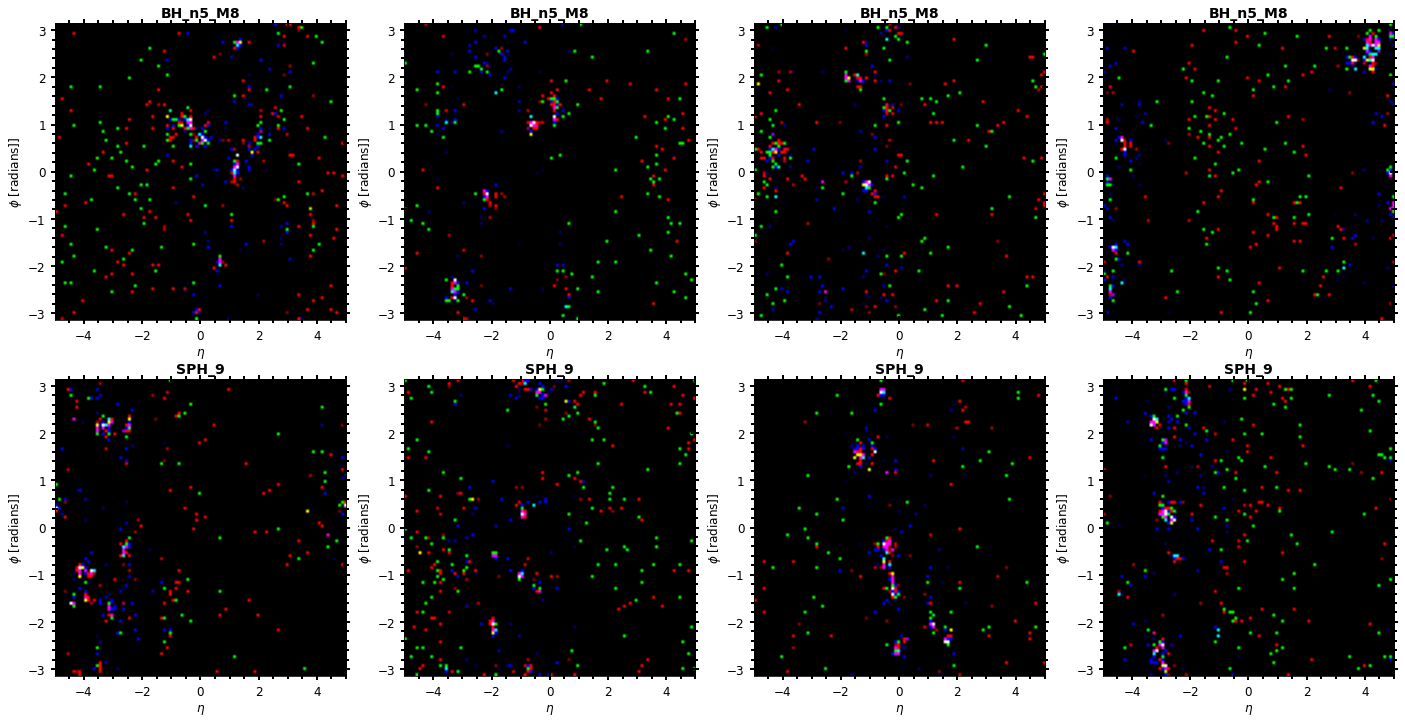

In [11]:
view_data(train_data, 4, CLASSES, LABELS, RES, TRAIN_N_EVENTS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[ 266.34872  285.56497  308.9948   325.2481   333.9619   421.2211
  442.10403  866.812   1016.35956]
Looking at image 1869


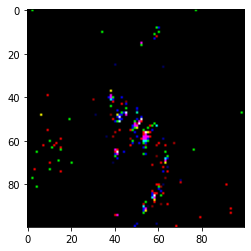

In [ ]:
k = np.random.randint(0, len(train_data))
image = train_data[k][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


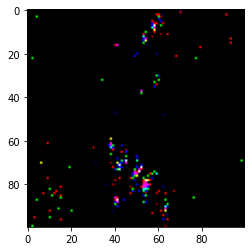

In [ ]:
#Check augmentation
transforms = torch.nn.Sequential(
        #torchv.transforms.RandomVerticalFlip(),
        #torchv.transforms.RandomHorizontalFlip(),
        #RandomRoll(1),
        RandomRoll(0)
)
if transforms!=None:
    rolled_image = transforms(image)
    plt.imshow(rolled_image)

### Create net and train

In [ ]:
#create NN and test that nothing major is wrong.
from resnet import ResNet18
resnet = ResNet18(img_channels=3, num_classes=CLASSES)
resnet.to(DEVICE)

#testimage, testlabel = traindata.images[0], traindata.img_labels[0]
testimage, testlabel = train_data[0][0], train_data[0][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(DEVICE)))

torch.Size([1, 3, 100, 100])
tensor([[0.6135, 0.1180]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
training_results = train(resnet, train_data, test_data, 2**7, 5, RES, DEVICE, optimizer)

100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


<AxesSubplot:xlabel='Iteration'>

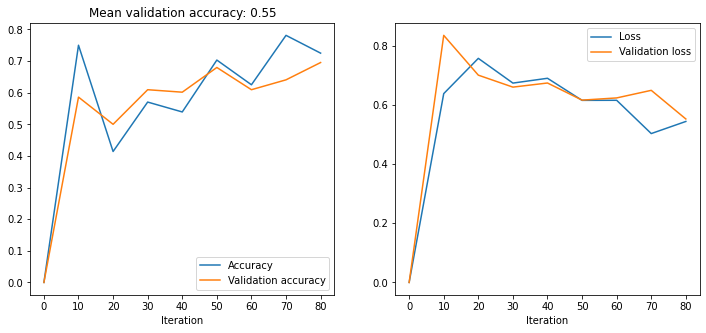

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])
#axs[0].set_ylim(0.6, 1)

In [ ]:
truth, preds = predict(resnet, test_data, 100, RES, DEVICE)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 60/60 [00:04<00:00, 12.15it/s]


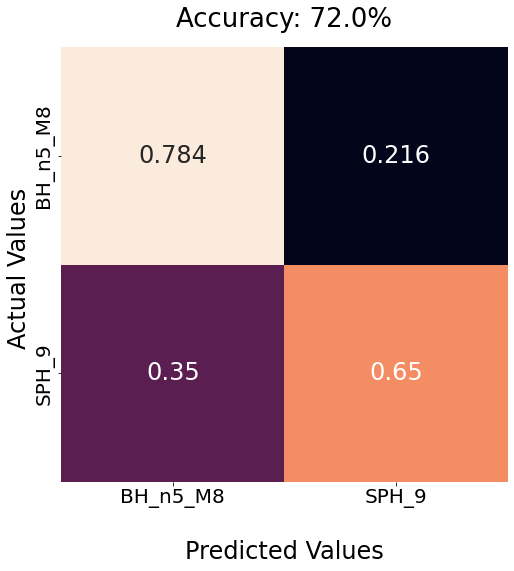

In [ ]:
plot_conf_matrix(confusion, accuracy, LABELS)

In [ ]:
print(torch.cuda.memory_summary(device=DEVICE, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   91153 KB |    1765 MB |  548630 MB |  548541 MB |
|       from large pool |   70240 KB |    1744 MB |  542614 MB |  542546 MB |
|       from small pool |   20913 KB |      35 MB |    6016 MB |    5995 MB |
|---------------------------------------------------------------------------|
| Active memory         |   91153 KB |    1765 MB |  548630 MB |  548541 MB |
|       from large pool |   70240 KB |    1744 MB |  542614 MB |